# Genetic Algorithm Approach

## Setup

Import necessary libraries and load the dataset.

In [1]:
import networkx as nx
import hashlib
import numpy as np
import json
from tqdm import tqdm
import copy
import os
import pickle
import matplotlib.pyplot as plt
import time
import statistics

In [2]:
g = nx.read_gml("./graphs/seidel_rally_graph-112_filtered.gml")
g.nodes

NodeView(('Weinstadt', 'Wachauer Weinstube', 'Glashütte', 'El Fuego', 'Unbedingt zur "Gerti"', 'Grande Cocktailbar', 'The Birdyard', 'Bierkanzlei', 'rhiz', 'Achtundzwanzig', 'Mausi', 'Pub by Charles', 'Travelshack Vienna', 'Mariahilfer Bräu', 'Nostalgija Kafana & Rakija Bar', 'Der Dachboden im 25hours Hotel beim MuseumsQuartier', 'Buffalos Saloon', 'The Lizard - Pub & Billards', 'Camillo', 'MEERU', 'Istros', 'Zum Schlauch', 'Failys', 'Pilwax', 'Cafe Else', 'Bastille-Pub', 'Oskar', 'Anton Frank - cafe bar', 'Einfach So', 'd.e.r. Location', 'Just 4 Fun', 'Sekt comptoir', 'Cafe Nest', 'Porto', 'Výtopna', 'Schwarzer Rabe', 'das Bach', 'Cafe C.I.', 'The green bogey', 'la Salvia', 'KUKU', "Barfly's", 'Ammutsøn Craft Beer Dive', 'Känguruh', 'Mon Ami', 'Aurora Rooftop Bar', 'Bermuda WG', 'Bräuhaus Ten.Fifty', 'Sportkantine Deniz Bank Arena', "Guggi's Beisl", 'Flanagans', "Dino's Apothecary Bar", 'Grüner Kakadu', 'Monte Ofelio Bar', 'Heartbeat', 'O’Connor’s Old Oak Irish Pub', "Raven's Pub", 'R

## Create initital Population

In [3]:
def enumerate_reversed(l):
    return zip(range(len(l)-1, -1, -1), reversed(l))

In [4]:
def init_pop(bar_graph, n_population):
    """
    Generate a randomly initialized population of bar routes
    Input:
        1. bar_graph: Graph of all bars
        2. n_population: Size of initial population
    Output:
        List of initial population
    """

    population = []

    for _ in range(n_population):
        route = []

        for idx in range(23, 0, -1):
            district_bars = [node for node, value in bar_graph.nodes(data=True) if value["district"] == idx]
            selected_bar = np.random.choice(district_bars)
            route.append(selected_bar)

        population.append(route)
    
    return population

## Create Fitness Function

In [5]:
def total_distance(graph, route):
    """
    Calculate total distance for a route.
    Input:
        graph: Graph of bars
        route: List of visited bars
    Output:
        tot_dist: The total distance of the route
    """

    #tot_dist = 0
    #for i in range(22):
    #    tot_dist += graph.get_edge_data(route[i], route[i+1])["weight"]
    tot_dist = nx.path_weight(graph, route, weight='weight')
    
    return tot_dist

In [6]:
def fitness(graph, pop):
    """
    Calculate fitness for each route.
    Input: 
        graph: Graph of bars
        pop: List of routes
    Output:
        pop_fit: List of fitness
    """
    
    pop_fit = []
    for route in pop:
        #tot_dist = total_distance(graph, route)
        pop_fit.append(1 / nx.path_weight(graph, route, weight='weight'))

    return pop_fit

## Create Selection Process

In [7]:
def roulette_wheel(pop_fitness, size_perc):
    """
    Create a roulette wheel that lets one random route survive.
    Probability is based on fitness.
    Input:
        pop_fitness: List of fitness
        size_perc: Percentage of population to select
    Output:
        idx: List of indexes of surviving units
    """

    population_fitness = np.array(pop_fitness)
    total_fitness = np.sum(pop_fitness)
    surv_prob = population_fitness / total_fitness

    cumsum_surv_prob = np.cumsum(surv_prob)

    idx = []
    for i in range(int(len(population_fitness) * size_perc)):
        rand_val = np.random.uniform(0, 1)
        selected_idx = np.where(cumsum_surv_prob >= rand_val)[0][0]
        idx.append(selected_idx)

    #idx = np.random.sample(range(int(len(population_fitness) * size_perc)), p=surv_prob)

    return idx

## Create Mutation Process

In [8]:
def mutation(graph, population, prob):
    """
    Mutate a random bar in a random district in each route by a certain probability.
    Input:
        graph: The graph containing the data
        population: List containing the routes
        prob: The porpability by which a mutation should happen
    Output:
        mutated_population: List containing the mutated routes
    """
    
    mutated_population = copy.deepcopy(population)
    mutation_mask = prob > np.random.uniform(0, 1, len(population))
    mutation_idx = np.argwhere(mutation_mask).flatten()
    dist_idx = list(range(23, 0, -1))

    for idx in mutation_idx:
        dist = np.random.randint(1, 24)
        dist_i = dist_idx[dist-1]
        
        current_bar = mutated_population[idx][dist_i-1]
        dist_bars = [node for node, value in graph.nodes(data=True) if value["district"] == dist]

        mutated_population[idx][dist_i-1] = np.random.choice([loc for loc in dist_bars if loc != current_bar])

    return mutated_population
        

## Create Crossover Process

In [9]:
def crossover(route_1, route_2):
    """
    Swap two routes after cutoff
    Input:
        route_1: List of bars
        route_2: Second list of bars
    Output:
        cross_1: New route
        cross_2: Second new route
    """
    
    cross_1 = []
    cross_2 = []
    for loc_1, loc_2 in zip(route_1, route_2):
        if np.random.rand() > 0.5:
            cross_1.append(loc_1)
            cross_2.append(loc_2)
        else:
            cross_1.append(loc_2)
            cross_2.append(loc_1)

    return cross_1, cross_2

## Putting it all together

In [10]:
def seidel_ralley_ga(bar_graph, epochs, n_pop, crossover_perc, mutation_prob):
    '''
    Run the entire GA
    Input:
        bar_graph: Graph containing the bars
        epochs: Number of generations to run
        n_pop: Size of population
        crossover_perc: Percentage of children to elite
        mutation_prob: Probability of mutation in children
    Output:
        best_paths: List containing best path for each generation
        best_lengths: Corresponding lengths for best paths
    '''

    #create initial population
    population = init_pop(bar_graph, n_pop)
    best_paths = []
    best_lengths = []

    for epoch in tqdm(range(epochs)):
        #get fitness of current population
        pop_fitness = fitness(bar_graph, population)
        
        best_lengths.append(total_distance(bar_graph, population[np.argsort(pop_fitness)[::-1][0]]))
        best_paths.append(population[np.argsort(pop_fitness)[::-1][0]])

        #run selection process
        parents_idx = roulette_wheel(pop_fitness, crossover_perc)

        #run crossover
        children = []
        num_children = int(n_pop * crossover_perc)
        if num_children % 2 == 1:
            num_children -= 1
        for i in range(0, num_children, 2):
            child1, child2 = crossover(population[parents_idx[i]], population[parents_idx[i+1]])
            children.extend([child1, child2])
        
        #run mutation
        mutated_children = mutation(bar_graph, children, mutation_prob)

        #replace part of the population
        pop_fit_sort_idx = np.argsort(pop_fitness)[::-1]
        elite = [population[j] for j in pop_fit_sort_idx[:n_pop - len(mutated_children)]]

        mutated_children.extend(elite)
        population = mutated_children
        
        
    return best_paths, best_lengths

In [11]:
best_paths, best_lengths = seidel_ralley_ga(g, 100, 500, 0.8, 0.05)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.18it/s]


In [12]:
best_lengths[-1]

21744.0

In [13]:
for bar in best_paths[-1]:
    print(bar, [value["district"] for node, value in g.nodes(data=True) if node == bar])

Köö Billardcafe [23.0]
Kagraner Kistl [22.0]
Star Voice Lounge [21.0]
Cafe Miami [20.0]
Unders [19.0]
Einfach So [18.0]
Senator Bar [17.0]
das Bach [16.0]
Mausi [15.0]
Gaby's Treff [14.0]
Brandauers Bierstube [13.0]
Die Mia [12.0]
Café Frog [11.0]
Guggi's Beisl [10.0]
Wachauer Weinstube [9.0]
The Birdyard [8.0]
Camillo [7.0]
KUKU [6.0]
The Black Sheep [5.0]
Výtopna [4.0]
Cadillac [3.0]
Istros [2.0]
Monte Ofelio Bar [1.0]


## Evaluation

In [14]:
iterations = 100
population = 500
cross_perc = 0.8
mutation_perc = 0.05

In [15]:
def hyperparameter_summary(iterations, population, cross_perc, mutation_perc):
    summary = (
        f"iter{iterations}_ants{population}_"
        f"evap{str(cross_perc).replace('.', '')}_"
        f"dep{str(mutation_perc).replace('.', '')}"
    )
    return summary

def calc_solutions():
    hp_name = hyperparameter_summary(iterations, population, cross_perc, mutation_perc)
    for i in range(1, 21):
        g = nx.read_gml(f"graphs/seidel_rally_graph-{i}_filtered.gml")
        result_file_path = f"ga_results/seidel_rally_graph-{i}_ga_results_{hp_name}.pkl"
        print(result_file_path)
        sol_paths = []
        sol_lengths = []
        sol_times = []
        if not os.path.exists(result_file_path):
            for random_seed in range(100):
                np.random.seed(random_seed)
                start_time = time.time()
                
                best_paths, best_lengths = seidel_ralley_ga(g, iterations, population, cross_perc, mutation_perc)
                best_lengths = [nx.path_weight(g, best_path, weight='weight') for best_path in best_paths]
                
                sol_paths.append(best_paths)
                sol_lengths.append(best_lengths)
                sol_times.append(time.time() - start_time)
                
            results = [best_lengths[-1] for best_lengths in sol_lengths]
            sol_stats = [min(results), statistics.mean(results), statistics.stdev(results)]
            
            with open(result_file_path, 'wb') as f:
                pickle.dump((sol_paths, sol_lengths, sol_times, sol_stats), f)
                

calc_solutions()

ga_results/seidel_rally_graph-1_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-2_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-3_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-4_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-5_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-6_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-7_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-8_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-9_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-10_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-11_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-12_ga_results_iter100_ants500_evap08_dep005.pkl
ga_results/seidel_rally_graph-13_ga_results_iter100_ants500_evap08_dep005

In [16]:
def construct_instance(g):
    # Add start and end node
    g.add_node('start')
    g.nodes['start']['district'] = float('inf')
    g.add_node('end')
    g.nodes['end']['district'] = float('-inf')
    
    # Connect start and end node to graph
    first_district_pubs = [n for n, attr in g.nodes(data=True) if attr['district'] == 1]
    last_district_pubs = [n for n, attr in g.nodes(data=True) if attr['district'] == 23]
    for node in last_district_pubs:
        g.add_edge('start', node, weight=0)
    
    for node in first_district_pubs:
        g.add_edge(node, 'end', weight=0)
    
    # Construct directed graph
    dg = nx.DiGraph()
    for u, v, attr in g.edges(data=True):
        if g.nodes[u]['district'] > g.nodes[v]['district']:
            dg.add_edge(u, v, weight=attr['weight'])
        else:
            dg.add_edge(v, u, weight=attr['weight'])
    
    return dg

In [17]:
def find_optimal_route(dg):
    shortest_path = nx.shortest_path(dg, source='start', target='end', weight='weight')
    return shortest_path[1:-1], nx.path_weight(dg, shortest_path, weight='weight')

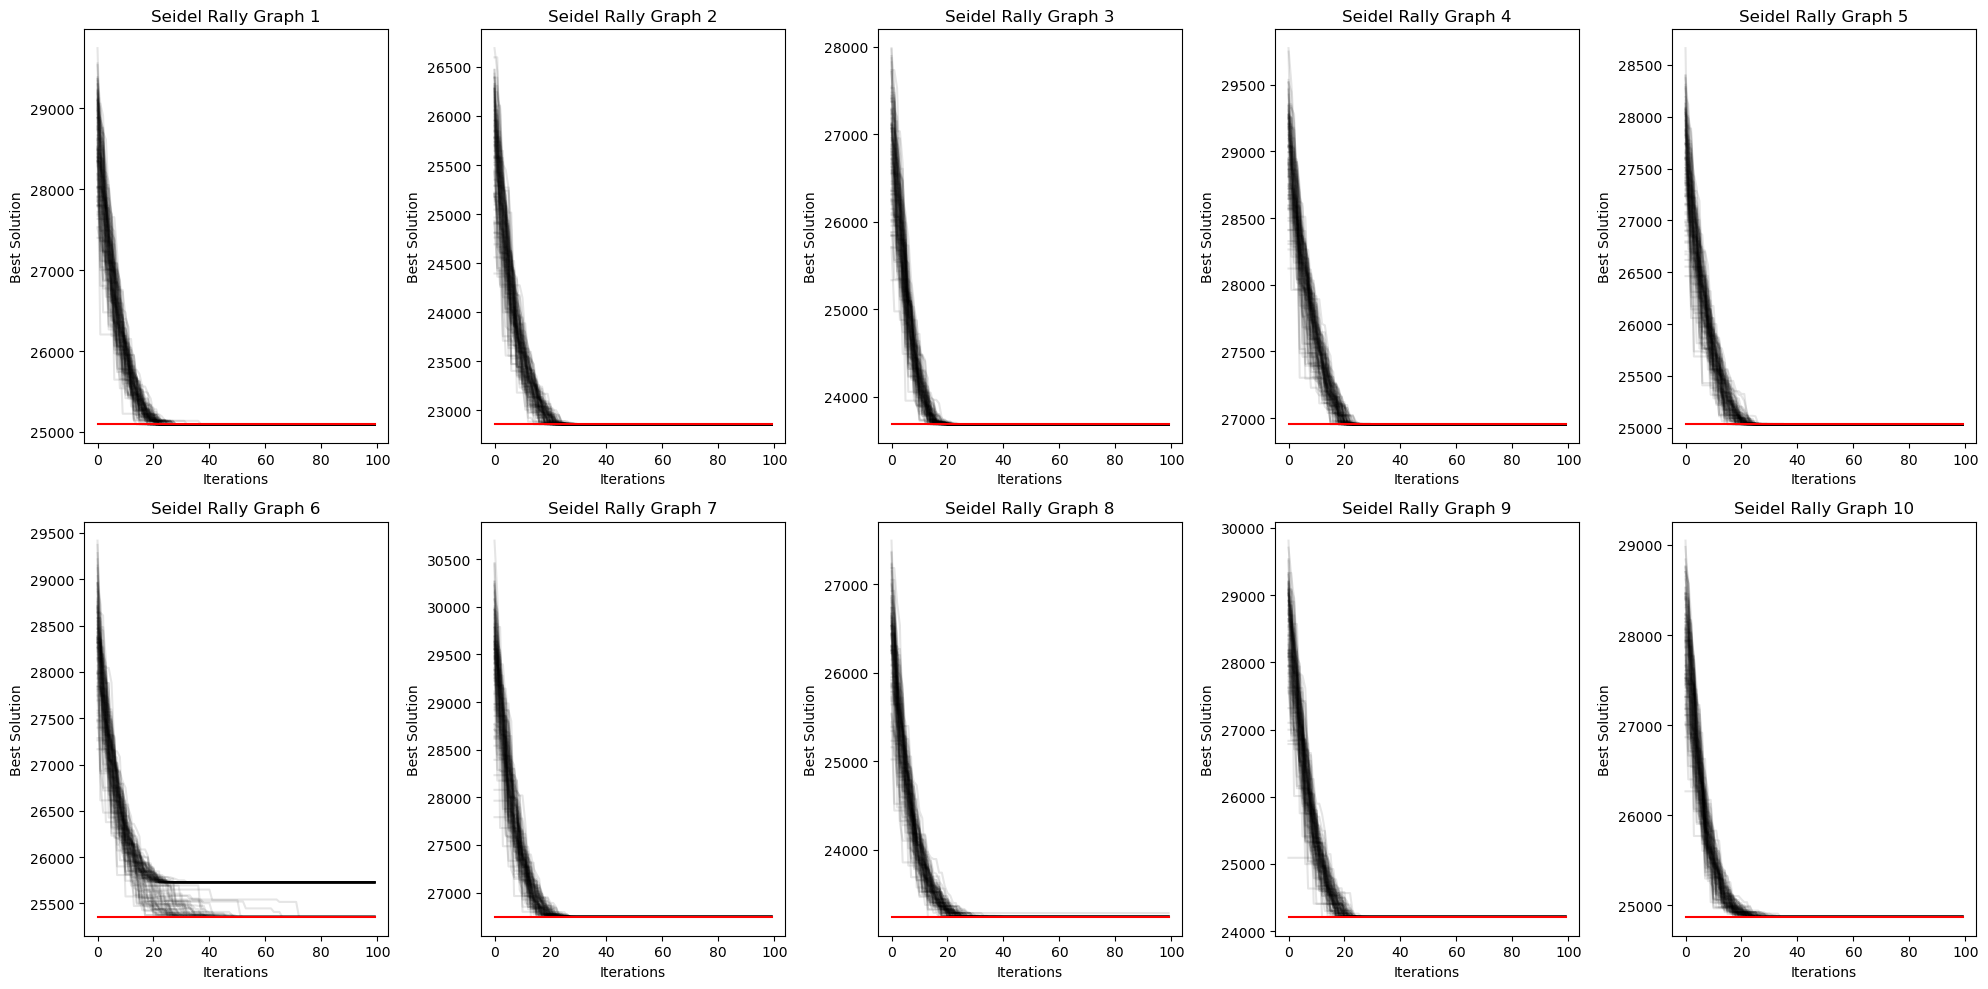

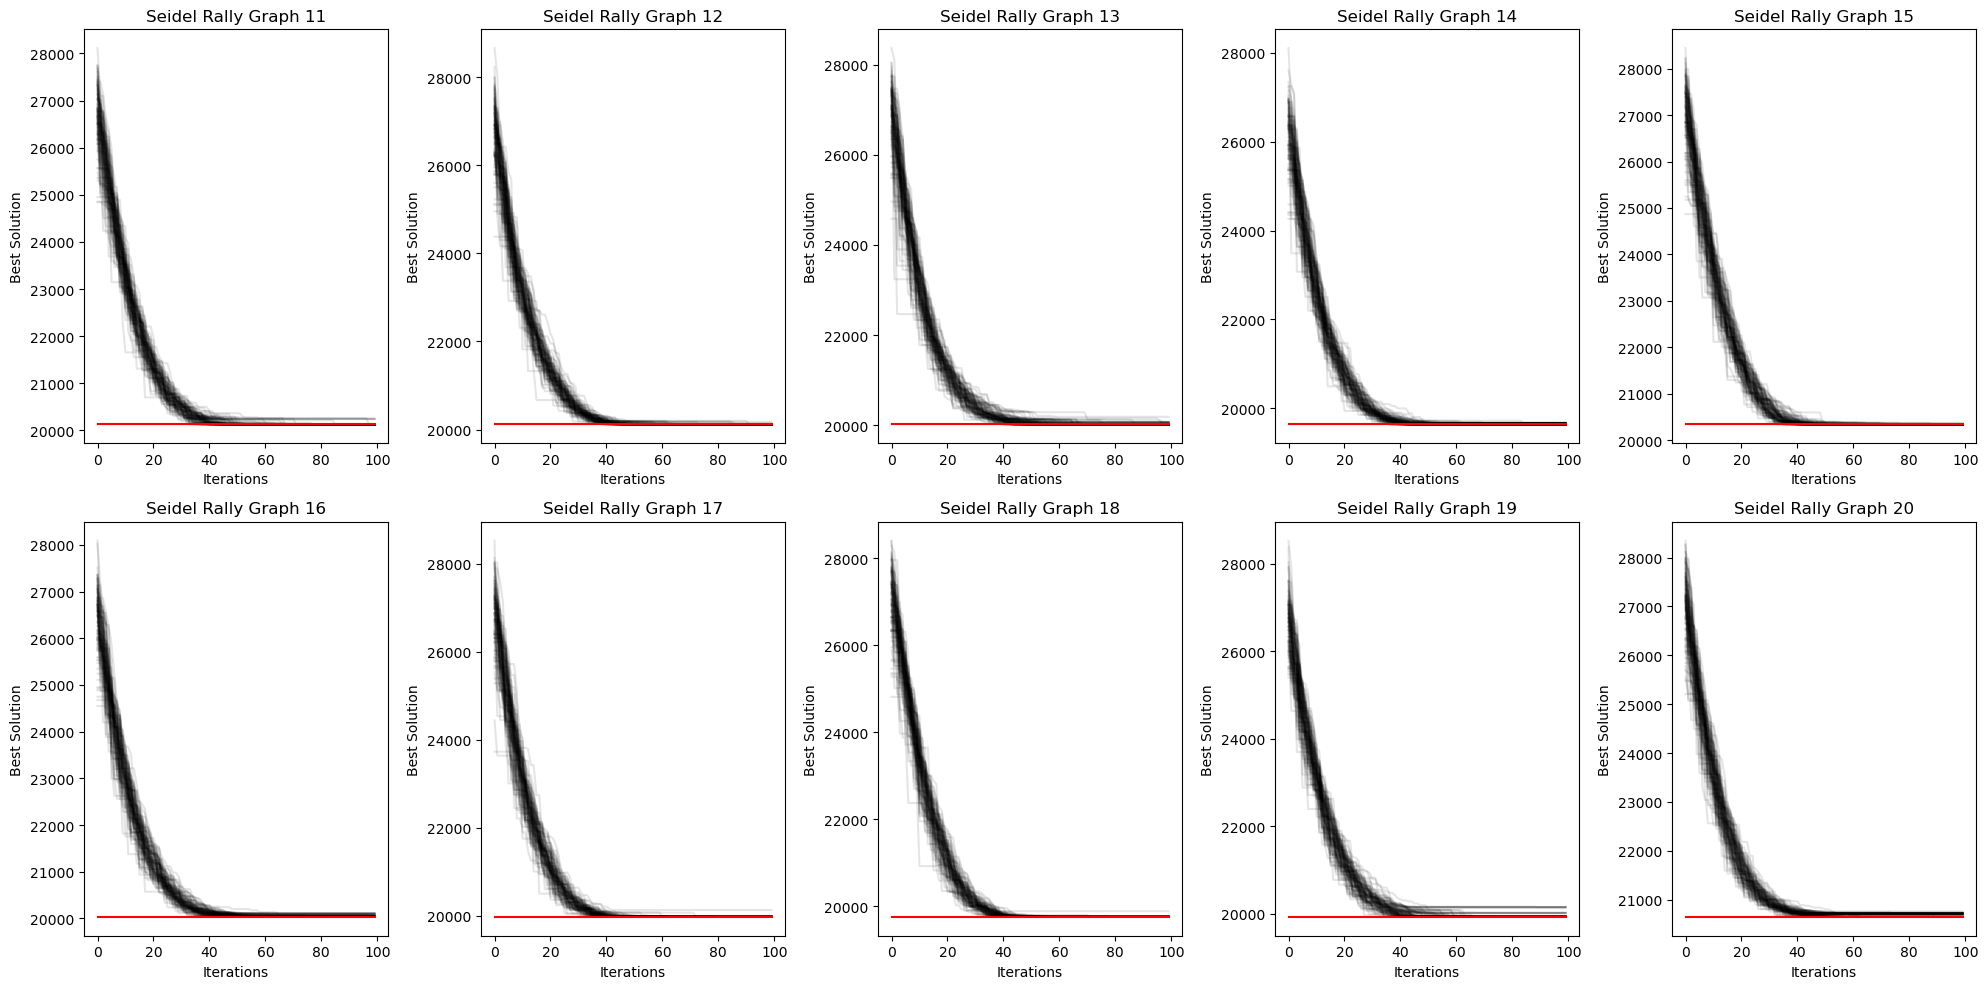

In [19]:
def plot_from_to(first, last):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    
    hp_name = hyperparameter_summary(iterations, population, cross_perc, mutation_perc)
    for i in range(first, last+1):
        g = nx.read_gml(f"graphs/seidel_rally_graph-{i}_filtered.gml")
        dg = construct_instance(g)
        opt_path, opt_length = find_optimal_route(dg)
        opt_length = nx.path_weight(g, opt_path, weight='weight')
        
        file_path = f"ga_results/seidel_rally_graph-{i}_ga_results_{hp_name}.pkl"
        with open(file_path, 'rb') as f:
            sol_paths, sol_lengths, sol_times, sol_stats = pickle.load(f)
    
        x = np.arange(iterations)
        for best_lengths in sol_lengths:
            axes[i-first].plot(x, best_lengths, label="GA", color='black', alpha=0.1)
        axes[i-first].plot(x, [opt_length] * iterations, label="Optimal", color='red')
        
        # Add labels and title
        axes[i-first].set_xlabel("Iterations")
        axes[i-first].set_ylabel("Best Solution")
        axes[i-first].set_title(f"Seidel Rally Graph {i}")
        
    # Show the plot
    plt.tight_layout()
    hp_name = hyperparameter_summary(iterations, population, cross_perc, mutation_perc)
    plt.savefig(f"ga_results_graphs{first}-{last}_{hp_name}.png", format='png')
    plt.show()

    

plot_from_to(1, 10)
plot_from_to(11, 20)